<a href="https://colab.research.google.com/github/mille055/AIPI540_individual_project/blob/main/notebooks/AIPI540_IP_fusion_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

In [1]:
COLAB_FLAG = False   # whether running on colab or locally on computer

In [2]:
if COLAB_FLAG:
    !pip install pydicom==2.1.2
    !pip install monai seaborn
    !git clone 'https://github.com/mille055/AIPI540_individual_project.git'

    


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import torchvision
import pydicom
import monai
import pickle
import glob
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, GroupKFold, cross_val_score, cross_validate, GroupShuffleSplit, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, plot_confusion_matrix, ConfusionMatrixDisplay

import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
import os
import copy
from datetime import datetime
from pprint import pprint


import monai
from monai.data import DataLoader, ImageDataset
from monai.transforms import AddChannel, Compose, RandRotate90, Resize, ScaleIntensity, EnsureType
from pydicom.dataset import Dataset as DcmDataset
from pydicom.tag import BaseTag as DcmTag
from pydicom.multival import MultiValue as DcmMultiValue
import sys
import warnings
warnings.filterwarnings("ignore")

In [4]:
#local imports
if COLAB_FLAG:
    sys.path.append('/content/AIPI540_individual_project/scripts/')

else: # running locally
    sys.path.append('/Users/cmm/Documents/GitHub/AIPI540_individual_project/scripts/')

### local imports ###
from config import file_dict, feats, column_lists
from config import abd_label_dict, val_list, train_val_split_percent, random_seed, data_transforms
from config import sentence_encoder, series_description_column, text_label
from utils import *

# from AIPI540_individual_project.scripts.train_pixel_model import train_model
# from AIPI540_individual_project.scripts.train_text_model import load_text_data, train_text_model, list_incorrect_text_predictions
# from AIPI540_individual_project.scripts.utils import *

2023-04-06 22:59:13,763 - NumExpr defaulting to 8 threads.


# Load Datasets


In [5]:
if COLAB_FLAG:
    train_datafile = '/content/AIPI540_individual_project/data/trainfiles.csv'
    test_datafile = '/content/AIPI540_individual_project/data/testfiles.csv'
else:
    # for local
    train_datafile = '../data/trainfiles.csv'
    test_datafile = '../data/testfiles.csv'

In [6]:
# def load_csv_dataset(train_file, test_file, val = True, val_lists = None):
#     train_df = pd.read_csv(train_file)
#     test_df = pd.read_csv(test_file)
#     train_df.drop('Unnamed: 0', axis=1, inplace=True)
#     test_df.drop('Unnamed: 0', axis=1, inplace=True)
#     if val:
#         if val_lists:
#             val_df = train_df[train_df.patientID.isin(val_lists)]
#             train_df = train_df[~train_df.index.isin(val_df.index)] 
#         else:
#             train_set, val_set = next(GroupShuffleSplit(test_size=.20, n_splits=1, random_state = 42).split(train_df, groups=train_df['patientID']))
#             train_df, val_df = train_set, val_set
#         return train_df, val_df, test_df

#     else: 
#         return train_df, test_df


In [6]:
train, val, test = load_csv_dataset(train_datafile, test_datafile, val_lists = val_list)
train = shorten_df(train)
val = shorten_df(val)
test = shorten_df(test)

In [7]:

train


,label,patientID,series,file_info
0,8,104,18(35-68),/volumes/cm7/Abdominal_MRI_dataset_split/train/104/exam1/18 (35-68)/0052.dcm
1,8,104,18(1-34),/volumes/cm7/Abdominal_MRI_dataset_split/train/104/exam1/18 (1-34)/0018.dcm
2,16,104,20,/volumes/cm7/Abdominal_MRI_dataset_split/train/104/exam1/20/0037.dcm
3,9,104,9,/volumes/cm7/Abdominal_MRI_dataset_split/train/104/exam1/9/0017.dcm
4,9,104,11,/volumes/cm7/Abdominal_MRI_dataset_split/train/104/exam1/11/0017.dcm
...,...,...,...,...
1407,7,94,3,/volumes/cm7/Abdominal_MRI_dataset_split/train/094/exam1/3/0015.dcm
1408,2,94,12,/volumes/cm7/Abdominal_MRI_dataset_split/train/094/exam1/12/0037.dcm
1409,2,94,13,/volumes/cm7/Abdominal_MRI_dataset_split/train/094/exam1/13/0037.dcm
1410,19,94,5,/volumes/cm7/Abdominal_MRI_dataset_split/train/094/exam1/5/0037.dcm


In [9]:
# import importlib
# import utils

# importlib.reload(utils)

In [8]:
def prepare_df(df):
    df1 = df.copy()
    filenames = df1.file_info.tolist()
    getdicoms = pd.DataFrame.from_dicoms(filenames)
    merged = getdicoms.merge(df1, left_on='fname', right_on='file_info')
    merged.drop(columns=['file_info'], inplace=True)
    artpooled = pool_arterial_labels(merged)
    artpooled['contrast'] = artpooled.apply(detect_contrast, axis=1)
    artpooled['plane'] = artpooled.apply(compute_plane, axis=1)
    # Keep only the rows where the 'label' column value is not in the excluded list
    df_filtered = artpooled[~artpooled['label'].isin([21,22,26,27,28,29])] 

    return artpooled

In [9]:

train_df = prepare_df(train)
val_df = prepare_df(val)
test_df = prepare_df(test)



In [33]:
train_df

,ImageType,SOPClassUID,SeriesDescription,ContrastBolusAgent,BodyPartExamined,ScanningSequence,SequenceVariant,ScanOptions,MRAcquisitionType,AngioFlag,...,PhotometricInterpretation,PixelSpacing,fname,TriggerTime,InversionTime,label,patientID,series,contrast,plane
0,"[DERIVED, PRIMARY, DIFFUSION, TRACEW, DIS2D]",MR Image Storage,ax diff_TRACEW,Multihance,ABDOMEN,EP,"[SK, SP]","[PFP, SFS]",2D,N,...,MONOCHROME2,"[0.9375, 0.9375]",/volumes/cm7/Abdominal_MRI_dataset_split/train/104/exam1/18 (35-68)/0052.dcm,NaN,NaN,8,104,18(35-68),1,ax
1,"[DERIVED, PRIMARY, DIFFUSION, TRACEW, DIS2D]",MR Image Storage,ax diff_TRACEW,Multihance,ABDOMEN,EP,"[SK, SP]","[PFP, SFS]",2D,N,...,MONOCHROME2,"[0.9375, 0.9375]",/volumes/cm7/Abdominal_MRI_dataset_split/train/104/exam1/18 (1-34)/0018.dcm,NaN,NaN,8,104,18(1-34),1,ax
2,"[ORIGINAL, PRIMARY, M, NORM, DIS2D]",MR Image Storage,ax equilibrium,Multihance,ABDOMEN,GR,"[SP, OSP]","[PFP, FS]",3D,N,...,MONOCHROME2,"[0.703125, 0.703125]",/volumes/cm7/Abdominal_MRI_dataset_split/train/104/exam1/20/0037.dcm,NaN,NaN,16,104,20,1,ax
3,"[ORIGINAL, PRIMARY, M, NORM, DIS2D]",MR Image Storage,ax haste bh,NaN,ABDOMEN,SE,"[SK, SP, OSP]","[PFP, SAT2, SFS]",2D,N,...,MONOCHROME2,"[1.5625, 1.5625]",/volumes/cm7/Abdominal_MRI_dataset_split/train/104/exam1/9/0017.dcm,NaN,NaN,9,104,9,0,ax
4,"[ORIGINAL, PRIMARY, M, NORM, DIS2D]",MR Image Storage,ax t2 triggerred,NaN,ABDOMEN,SE,"[SK, SP]","[PFP, SAT2, FS]",2D,N,...,MONOCHROME2,"[1.5625, 1.5625]",/volumes/cm7/Abdominal_MRI_dataset_split/train/104/exam1/11/0017.dcm,NaN,NaN,9,104,11,0,ax
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407,"[ORIGINAL, PRIMARY, M, NORM, DIS2D]",MR Image Storage,cor haste,NaN,ABDOMEN,SE,"[SK, SP, OSP]",PFP,2D,N,...,MONOCHROME2,"[1.5625, 1.5625]",/volumes/cm7/Abdominal_MRI_dataset_split/train/094/exam1/3/0015.dcm,NaN,NaN,7,94,3,0,cor
1408,"[ORIGINAL, PRIMARY, M, NORM, DIS2D]",MR Image Storage,ax dyn,Multihance,ABDOMEN,GR,"[SP, OSP]","[PFP, FS]",3D,N,...,MONOCHROME2,"[0.78125, 0.78125]",/volumes/cm7/Abdominal_MRI_dataset_split/train/094/exam1/12/0037.dcm,NaN,NaN,2,94,12,1,ax
1409,"[ORIGINAL, PRIMARY, M, NORM, DIS2D]",MR Image Storage,ax dyn,Multihance,ABDOMEN,GR,"[SP, OSP]","[PFP, FS]",3D,N,...,MONOCHROME2,"[0.78125, 0.78125]",/volumes/cm7/Abdominal_MRI_dataset_split/train/094/exam1/13/0037.dcm,NaN,NaN,2,94,13,1,ax
1410,"[ORIGINAL, PRIMARY, M, NORM, DIS2D]",MR Image Storage,ax dixon_opp,NaN,ABDOMEN,GR,SP,"[PFP, SAT2]",3D,N,...,MONOCHROME2,"[1.5625, 1.5625]",/volumes/cm7/Abdominal_MRI_dataset_split/train/094/exam1/5/0037.dcm,NaN,NaN,19,94,5,0,ax


In [34]:
X_train_meta = preprocess(train_df)
X_val_meta = preprocess(val_df)
X_test_meta = preprocess(test_df)
y = train_df.label


Preprocessing metadata for Random Forest classifier.
Have received 1412 entries.
Preprocessing metadata for Random Forest classifier.
Have received 354 entries.
Preprocessing metadata for Random Forest classifier.
Have received 446 entries.


In [12]:
feats_to_keep = [col for col in X_train_meta.columns if X_train_meta[col].nunique() > 1]


TypeError: unhashable type: 'MultiValue'

In [ ]:
#### train metadata model code to repo...

In [13]:
def meta_inference(df, model, feature_list=feats):
    X = preprocess(df)[feature_list]
    y = df.label
    preds = model.predict(X)
    probs = model.predict_proba(X)
    acc = np.sum(preds==y)/len(y)


    return preds, probs, y, acc
    

## Get Inferences from Saved Models

In [25]:
# Load the pickled model
with open('../models/meta_04062023_optmodel.skl', 'rb') as file:
    meta_model = pickle.load(file)



In [38]:
Tpreds, Tprobs, Ty, Tacc = meta_inference(train_df, meta_model, feats)
Vpreds, Vprobs, Vy, Vacc = meta_inference(val_df, meta_model, feats)
TEpreds, TEprobs, TEy, TEacc = meta_inference(test_df, meta_model, feats)

Preprocessing metadata for Random Forest classifier.
Have received 1412 entries.
Preprocessing metadata for Random Forest classifier.
Have received 354 entries.
Preprocessing metadata for Random Forest classifier.
Have received 446 entries.


In [58]:
def make_meta_results_df(preds, probs, true, df):
    return pd.DataFrame({'preds': preds, 'true': true, 'probs': [row.tolist() for row in probs], 'patientID': df['patientID'], 'series_description': df['SeriesDescription'], 'contrast': df['contrast'], 'plane': df['plane']  })



In [60]:
meta_model.classes_

array([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 25, 26, 28, 29])

In [69]:

train_results_df = make_meta_results_df(Tpreds, Tprobs, Ty, train_df)
val_results_df = make_meta_results_df(Vpreds, Vprobs, Vy, val_df)
test_results_df = make_meta_results_df(TEpreds, TEprobs, TEy, test_df)
meta_vector = Tprobs

In [70]:
meta_vector

array([[1.47947497e-01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 6.45661157e-05],
       [1.47947497e-01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 6.45661157e-05],
       [0.00000000e+00, 9.51069133e-05, 7.69871361e-02, ...,
        0.00000000e+00, 0.00000000e+00, 6.89068573e-04],
       ...,
       [0.00000000e+00, 4.91932310e-05, 9.26785777e-01, ...,
        0.00000000e+00, 2.61521918e-04, 1.54297216e-04],
       [9.08182726e-05, 0.00000000e+00, 5.35009992e-03, ...,
        8.93046348e-04, 1.80592615e-03, 1.92321048e-04],
       [0.00000000e+00, 4.91932310e-05, 9.26785777e-01, ...,
        0.00000000e+00, 2.61521918e-04, 1.54297216e-04]])

In [28]:
print(classification_report(TEpreds, TEy))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.59      0.56      0.58        64
           6       0.82      0.22      0.34        65
           7       1.00      0.96      0.98        23
           8       1.00      1.00      1.00        43
           9       1.00      0.98      0.99        43
          11       0.76      0.96      0.85        23
          12       0.00      0.00      0.00         2
          13       0.67      1.00      0.80         2
          14       1.00      1.00      1.00        23
          16       0.09      0.25      0.13         8
          17       1.00      1.00      1.00        21
          18       0.93      1.00      0.96        26
          19       0.65      0.75      0.70        20
          21       1.00      0.36      0.53        14
          22       0.00      0.00      0.00         0
          23       0.00      0.00      0.00         0
          25       0.70    

In [ ]:
## get pixel based inference


ValueError: The number of FixedLocator locations (19), usually from a call to set_ticks, does not match the number of ticklabels (25).

<Figure size 1800x1800 with 0 Axes>

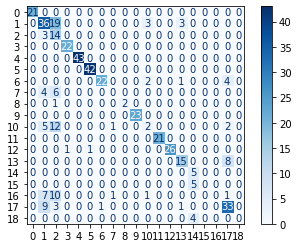

In [29]:
from datetime import datetime
cm = confusion_matrix(TEy, TEpreds)

# yvals= sorted(y.unique())
    
# labels = yvals
# target_names = [abd_label_dict[str(x)] ['short'] for x in yvals]

plt.figure(figsize=(25, 25))
plt.tight_layout()
ConfusionMatrixDisplay(cm, display_labels=meta_model.classes_).plot(xticks_rotation = 'vertical', cmap='Blues')
plt.savefig("../assets/FigCM_meta"+datetime.today().strftime('%Y%m%d')+".tif",dpi=300, bbox_inches = 'tight')

In [ ]:
### BOOOO the model did not work on this dataset with different columns and all labels (not just MBreduced)


In [14]:
from train_meta_model import train_fit_parameter_trial
new_opt_model = train_fit_parameter_trial(X_train_meta, y, feats, fname='meta_04062023_optmodel.skl')


Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 2,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'bootstrap': False,
 'max_depth': 226,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 121}


In [15]:
new_opt_model

RandomForestClassifier(bootstrap=False, max_depth=226, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=121, n_jobs=2,
                       random_state=0)

In [43]:
# old_version_cols = old_version.columns
# new_version_cols = train_df.columns

# #diff = list(set(old_version_cols) ^ set(new_version_cols))
# #[print(x) for x in diff]

# omn = set(old_version_cols)-set(new_version_cols)
# [print(x) for x in omn]


In [ ]:
# fns = train.file_info.tolist()

# # Create an empty list to store the DICOM metadata
# data = []

# # Loop over the DICOM file names and extract the metadata
# for file_name in file_names:
#     # Read in the DICOM file
#     ds = pydicom.dcmread(file_name)
    
#     d = {}
#     for col in dicom_cols:
#         d.key = col
#         d.value = ds['col']
#     # Store the metadata in a dictionary
#     d = {
#         'patient_id': patient_id,
#         'study_date': study_date,
#         # ... add other metadata as needed ...
#     }
    
#     # Append the dictionary to the data list
#     data.append(d)

# # Create a DataFrame from the data list
# df = pd.DataFrame(data)
# This code reads in a list of DICOM file names, then loops over the files and extracts the metadata of interest using pydicom. It stores the metadata in a dictionary, then appends the dictionary to a list of dictionaries (data). Finally, it creates a Pandas DataFrame from the list of dictionaries using pd.DataFrame(data). You can modify this code to extract the specific metadata that you are interested in from your DICOM files.








In [25]:
train_label_df = train[['fname_x', 'filename', 'Parent_folder', 'patientID', 'exam', 'series', 'SeriesDescription_y', 'plane', 'seq_label', 'contrast', 'original_label_code', 'ap_label_code']]
train_label_df.rename(columns={'SeriesDescription_y':'SeriesDescription'}, inplace=True)
train_label_df

KeyError: "['Parent_folder', 'contrast', 'seq_label', 'fname_x', 'plane', 'filename', 'exam', 'original_label_code', 'ap_label_code', 'SeriesDescription_y'] not in index"

In [ ]:
test_label_df = test[['fname_x', 'filename', 'Parent_folder', 'patientID', 'exam', 'series', 'SeriesDescription_y', 'plane', 'seq_label', 'contrast', 'original_label_code', 'ap_label_code']]
test_label_df.rename(columns={'SeriesDescription_y':'SeriesDescription'}, inplace=True)
test_label_df

,fname_x,filename,Parent_folder,patientID,exam,series,SeriesDescription,plane,seq_label,contrast,original_label_code,ap_label_code
0,Abdominal MRI data/102/exam1/16 (1-40)/0010.dcm,0010.dcm,Abdominal MRI data,102,exam1,16(1-40),ax diff_TRACEW,ax,dwi,0,8,8
1,Abdominal MRI data/102/exam1/16 (41-80)/0073.dcm,0073.dcm,Abdominal MRI data,102,exam1,16(41-80),ax diff_TRACEW,ax,dwi,0,8,8
2,Abdominal MRI data/102/exam1/18/0010.dcm,0010.dcm,Abdominal MRI data,102,exam1,18,ax equilibrium new,ax,equilibrium,1,16,16
3,Abdominal MRI data/102/exam1/11/0010.dcm,0010.dcm,Abdominal MRI data,102,exam1,11,ax dyn new,ax,early dynamic,1,3,2
4,Abdominal MRI data/102/exam1/7/0010.dcm,0010.dcm,Abdominal MRI data,102,exam1,7,ax dixon_W,ax,unknown,0,25,25
...,...,...,...,...,...,...,...,...,...,...,...,...
427,Abdominal MRI data/058/exam1/16 (1-36)/0010.dcm,0010.dcm,Abdominal MRI data,58,exam1,16(1-36),ax diff_TRACEW,ax,dwi,0,8,8
428,Abdominal MRI data/058/exam1/2/0010.dcm,0010.dcm,Abdominal MRI data,58,exam1,2,cor haste,cor,t2,0,7,7
429,Abdominal MRI data/058/exam1/13/0010.dcm,0010.dcm,Abdominal MRI data,58,exam1,13,ax dyn new,ax,early dynamic,1,2,2
430,Abdominal MRI data/058/exam1/5/0010.dcm,0010.dcm,Abdominal MRI data,58,exam1,5,ax dixon_in,ax,in phase,0,14,14


In [ ]:
# for colab
# trainids = pd.read_csv('/content/AIPI540_individual_project/data/trainfiles.csv')
# for local
trainids = pd.read_csv('./data/trainfiles.csv')


In [ ]:
trainids.iloc[6].file_info

'/volumes/cm7/Abdominal_MRI_dataset_split/train/104/exam1/18 (35-68)/0059.dcm'

In [ ]:
val_df = pd.read_pickle('/content/AIPI540_individual_project/data/val_dicom_data.pkl')

FileNotFoundError: [Errno 2] No such file or directory: '/content/AIPI540_individual_project/data/val_dicom_data.pkl'

In [ ]:
val_df

,label_code_x,predictions,patientID,series,img_label_code,GT label,prediction label,probability,original_label_code,SeriesDescription_y,plane,seq_label,contrast,label_code_y,final_prediction
0,8,8,41,16(37-72),8,dwi,dwi,0.976494,8,ax diff_TRACEW,ax,dwi,0,8,8
1,30,30,41,18,16,T1 post con,T1 post con fat sat,0.956994,16,ax equilibrium new,ax,equilibrium,1,16,16
2,30,30,41,11,3,T1 post con,T1 post con fat sat,0.956994,3,ax dyn new,ax,early dynamic,1,3,3
3,25,25,41,7,25,T1 fat sat,T1 fat sat,0.957891,25,ax dixon_W,ax,unknown,0,25,25
4,11,11,41,6,11,dixon fat,dixon fat,0.955352,11,ax dixon_F,ax,unknown,0,11,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,9,9,66,12,9,t2,t2,0.977097,9,ax t2 resp trig,ax,t2,0,9,9
350,7,7,66,2,17,t2,t2,0.914605,7,cor haste,cor,t2,0,7,7
351,11,11,66,5,11,dixon fat,dixon fat,0.834404,11,ax dixon top_F_FIL,ax,unknown,0,11,11
352,0,0,66,14,0,adc,adc,0.449541,0,ax diff_ADC,ax,dwi,0,0,0


In [ ]:
### does not have the filename colums.... will look for another
